In [ ]:

!pip install scikit-learn pandas matplotlib openpyxl

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, confusion_matrix, roc_curve, auc
)



In [2]:
from google.colab import files

In [14]:
df=files.upload()

Saving ml model.xlsx to ml model (2).xlsx


Initial shape: (9999, 48)
     FILENAME                                 URL   URLLength  \
0  521848.txt    https://www.southbankmosaics.com          31   
1   31372.txt            https://www.uni-mainz.de          23   
2  597387.txt      https://www.voicefmradio.co.uk          29   
3  554095.txt                          554095.txt  554095.txt   
4  151578.txt  https://www.rewildingargentina.org          33   

                       Domain DomainLength  IsDomainIP         TLD  \
0    www.southbankmosaics.com           24           0         com   
1            www.uni-mainz.de           16           0          de   
2      www.voicefmradio.co.uk           22           0          uk   
3                  554095.txt   554095.txt  554095.txt  554095.txt   
4  www.rewildingargentina.org           26           0         org   

  URLSimilarityIndex CharContinuationRate TLDLegitimateProb  ... Pay Crypto  \
0                100                    1          0.522907  ...   0      0   
1   

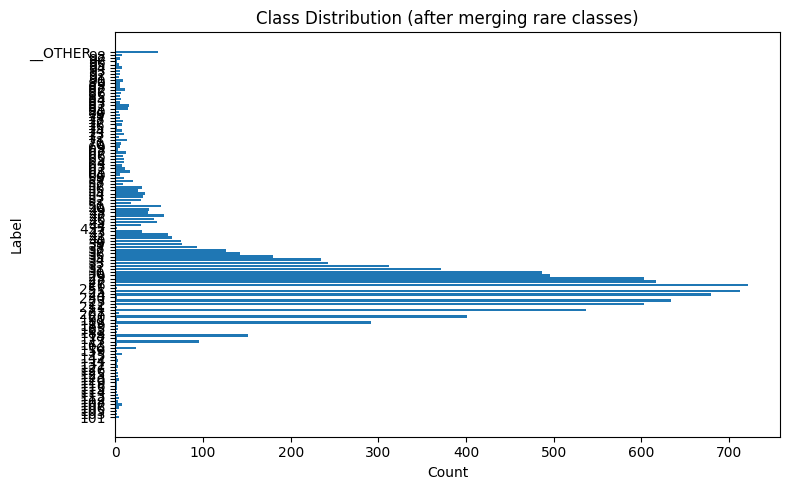


Confusion Matrix (rows=true, cols=pred):
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


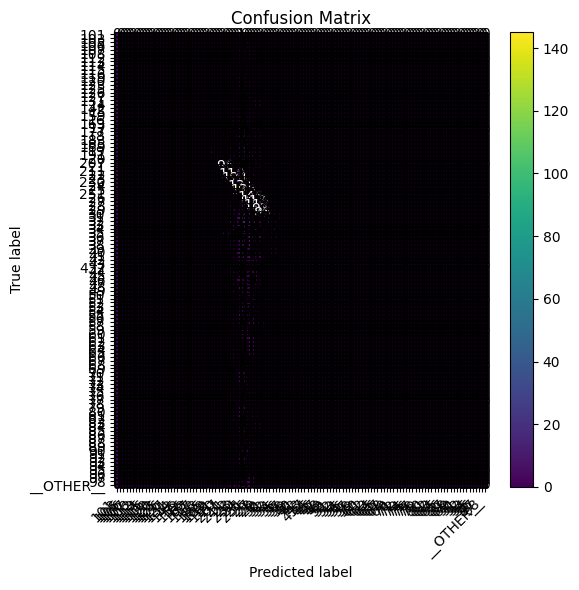


ROC curve skipped (more than 2 classes).


In [17]:
# Optional: run if packages are missing
# !pip install -q scikit-learn pandas matplotlib openpyxl

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder

# --- Load dataframe (adjust path if needed) ---
# If you already loaded df earlier, you can comment out the next line.
df = pd.read_excel(r"ml model.xlsx")

print("Initial shape:", df.shape)
print(df.head())
print("\nColumns:", list(df.columns))

# --- Ensure label exists ---
label_col = 'URLLength'
if label_col not in df.columns:
    raise KeyError(f"Column '{label_col}' not found in the dataframe.")

# --- Build y (original labels) and decide numeric vs categorical approach ---
# We'll treat label values as strings (categorical) for the classifier,
# but if most values are numeric we try converting and keep numeric grouping.
converted = pd.to_numeric(df[label_col], errors='coerce')
num_non_na = converted.notna().sum()
frac_numeric = num_non_na / len(df)
print(f"\nURLLength numeric conversion: {num_non_na}/{len(df)} rows numeric (fraction {frac_numeric:.2f})")

if frac_numeric >= 0.9:
    # Use numeric grouping (cast to int)
    df['URLLength_numeric'] = converted.astype('Int64')
    # drop rows where conversion failed
    df = df.dropna(subset=['URLLength_numeric'])
    y = df['URLLength_numeric'].astype(str)  # keep as string classes for LabelEncoder later
    print(f"Using numeric labels (kept as strings). New shape: {df.shape}")
else:
    # Keep original values as strings, drop NaNs in label
    df = df.dropna(subset=[label_col])
    y = df[label_col].astype(str)
    print(f"Using categorical/string labels. New shape: {df.shape}")

# --- Prepare features: drop the label columns and ensure there is at least one feature ---
drop_cols = [label_col]
if 'URLLength_numeric' in df.columns:
    drop_cols.append('URLLength_numeric')
X = df.drop(columns=drop_cols, errors='ignore')

if X.shape[1] == 0:
    raise ValueError("No feature columns remain after dropping the label. Ensure your dataset has feature columns.")

# Convert rows to single text strings for TF-IDF
X_text = X.astype(str).agg(' '.join, axis=1)  # pandas Series, same index as df

# --- Option A: merge rare classes into "__OTHER__" so stratify works ---
min_count = 2  # minimum samples per class required for stratify
counts = y.value_counts()
small = counts[counts < min_count].index.tolist()
print("\nSmall classes to merge (count < {}): {}".format(min_count, small))

if small:
    y_merged = y.replace({c: "__OTHER__" for c in small})
    # If __OTHER__ is still too small, drop those rows entirely
    if y_merged.value_counts().get("__OTHER__", 0) < min_count:
        drop_mask = y_merged == "__OTHER__"
        num_drop = drop_mask.sum()
        print(f"__OTHER__ has <{min_count} samples after merge; dropping those {num_drop} rows.")
        # drop from both X_text and y_merged to keep alignment
        X_text = X_text[~drop_mask]
        y_merged = y_merged[~drop_mask]
else:
    y_merged = y.copy()

# Final class counts after merging/dropping
print("\nFinal class counts:\n", y_merged.value_counts())

# --- Train/test split with stratify ---
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y_merged, test_size=0.2, random_state=42, stratify=y_merged
)

# --- Vectorize text ---
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train_text)
X_test_vec = vectorizer.transform(X_test_text)

# --- Encode labels consistently ---
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)  # yields integers 0..n-1 in same order as le.classes_

print("\nClasses (label encoder order):", list(le.classes_))

# --- Train classifier ---
model = MultinomialNB()
model.fit(X_train_vec, y_train_enc)
pred_enc = model.predict(X_test_vec)
acc = accuracy_score(y_test_enc, pred_enc)
print("\nAccuracy:", acc)

# --- Plot class distribution (safe plotting) ---
label_counts = pd.Series(y_merged).value_counts().sort_index()
plt.figure(figsize=(8,5))
if all(label_counts.index.str.isdigit()):
    # numeric-looking labels: convert to int for x-axis if safe
    try:
        xi = label_counts.index.astype(int)
        plt.bar(xi, label_counts.values)
        plt.xlabel("URLLength (numeric)")
    except Exception:
        plt.barh(label_counts.index.astype(str), label_counts.values)
        plt.xlabel("Count")
else:
    plt.barh(label_counts.index.astype(str), label_counts.values)
    plt.xlabel("Count")
plt.title("Class Distribution (after merging rare classes)")
plt.ylabel("Label")
plt.tight_layout()
plt.show()

# --- Confusion matrix ---
labels_order = le.classes_
cm = confusion_matrix(y_test_enc, pred_enc, labels=np.arange(len(labels_order)))
print("\nConfusion Matrix (rows=true, cols=pred):\n", cm)

plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', aspect='auto')
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(labels_order))
plt.xticks(tick_marks, labels_order, rotation=45, ha='right')
plt.yticks(tick_marks, labels_order)
thresh = cm.max() / 2 if cm.size else 0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# --- ROC curve (only for binary classification) ---
if len(labels_order) == 2:
    # predict_proba columns correspond to classes in le.classes_ order
    # pick the column corresponding to the positive class (index 1)
    y_prob = model.predict_proba(X_test_vec)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test_enc, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC={roc_auc:.3f})")
    plt.plot([0,1], [0,1], '--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()
else:
    print("\nROC curve skipped (more than 2 classes).")
